In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import grangercausalitytests
import pickle
from sklearn.model_selection import train_test_split
import re


from FRUFS import FRUFS
import matplotlib.pyplot as plt
import optuna
import joblib, gc
import lightgbm as lgb
import seaborn as sns

from sklearn.datasets import make_regression
from scipy.stats import pearsonr
from tqdm.notebook import trange, tqdm
from FRUFS import FRUFS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [39]:
# Unpickling the data
infile = open("Sun_Model_Data",'rb')
Model_Data = pickle.load(infile)
infile.close()

# Reading in the data
df = Model_Data.train_x
sun_y_train = Model_Data.train_y
sun_y_test = Model_Data.test_y
sun_x_test = Model_Data.test_x


# Defining FRUFS model with k=3 maximum features
model_frufs_generated = FRUFS(
        model_r=lgb.LGBMRegressor(random_state=42),
        k=8
        #categorical_features = ["#Buys", "# Hold", "# Sell", "Total Rec"]
    )
model_frufs_generated.fit(df)
# Saving the features selected by FRUFS in a seperate dataframe 
pruned_df = model_frufs_generated.transform(df)

# Training the model on the features selected by FRUFS
frufs_model = AutoReg(sun_y_train, lags=0, exog=pruned_df).fit()
# Calculating MAE train (.sqeeze is reuired when sun_y is saved as a DF and not series)
MAE_train = np.nanmean(abs(frufs_model.predict() - sun_y_train.squeeze()))

# Saving names of the features selected by FRUFS in a list
frufs_features = list(pruned_df.columns)

# Defining test dataset with only features selected by FRUFS 
frufs_x_test = sun_x_test[frufs_features]

# Defining first and last out-of-sample indices to predict
first_oos_ind = len(sun_y_train)
last_oos_ind = first_oos_ind + len(sun_y_test) - 1

# Predicting the oos ys with the test data
y_pred_out_frufs = frufs_model.predict(start=first_oos_ind, end=last_oos_ind, exog_oos=frufs_x_test)
# Resetting index to make MAE_test calcuation possible
y_pred_out_frufs.reset_index(drop=True, inplace=True)
# Calculating MAE Test
MAE_test = np.nanmean(abs(y_pred_out_frufs - sun_y_test.squeeze()))

print(f"MAE Train = {MAE_train}; MAE_test = {MAE_test}")


Progress bar: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

MAE Train = 0.3066087409198399; MAE_test = 0.28647790291079206


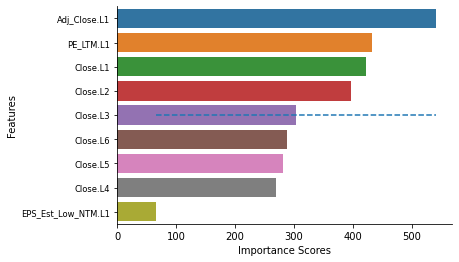

In [28]:
model_frufs_generated.feature_importance()

In [ ]:
# set up logging to console
console = logging.StreamHandler()
console.setLevel(logging.DEBUG)
# set a format which is simpler for console use
formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')
console.setFormatter(formatter)
# add the handler to the root logger
logging.getLogger('').addHandler(console)

logger = logging.getLogger(__name__)